# Analyse adaptive CPG output

In [1]:
# it's easiest to do pltting in jupyter...
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [123]:
with open('data/oscillator_CPG.txt','rb') as f:
	spikes = pickle.load(f)
spikes_array = np.vstack(([spike.timestamp for spike in spikes],[spike.id for spike in spikes])).T

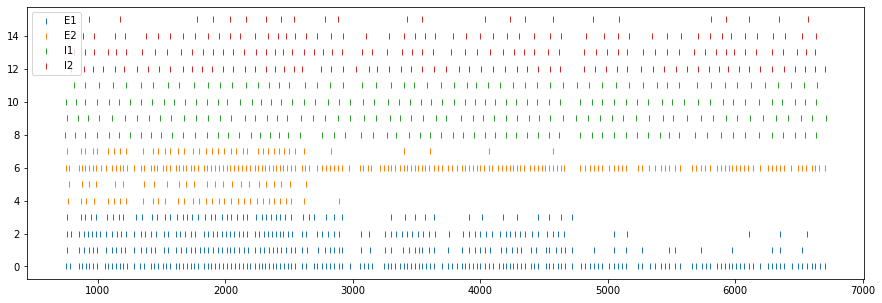

In [124]:
exc_spikes = spikes_array[spikes_array[:,1] < 256,:]
inh_spikes = spikes_array[spikes_array[:,1] >= 256,:]
e1 = exc_spikes[exc_spikes[:,1] < 4,:]
e2 = exc_spikes[exc_spikes[:,1] >= 4,:]
i1 = inh_spikes[inh_spikes[:,1]-256 < 4,:]
i2 = inh_spikes[inh_spikes[:,1]-256 >= 4,:]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()
ax.plot(e1[:,0]/1000, e1[:,1], '|', label='E1')
ax.plot(e2[:,0]/1000, e2[:,1], '|', label='E2')
ax.plot(i1[:,0]/1000, -256+8+i1[:,1], '|', label='I1')
ax.plot(i2[:,0]/1000, -256+8+i2[:,1], '|', label='I2')
plt.legend()
plt.show()

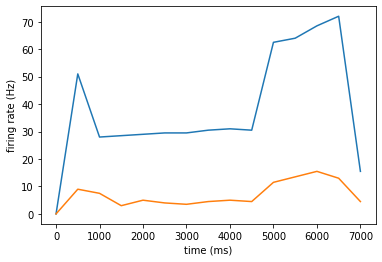

In [100]:
end = np.ceil(max(spikes_array[:,0])/500000)

# plt.plot(exc_spikes[:,0]//500000, '|')
# plt.show()
h_exc = np.histogram(exc_spikes[:,0]//500000, np.arange(end+1)-0.5)
h_inh = np.histogram(inh_spikes[:,0]//500000, np.arange(end+1)-0.5)
plt.plot(500*(h_exc[1][:-1]+0.5), h_exc[0] /4*1000/500)
plt.plot(500*(h_inh[1][:-1]+0.5), h_inh[0] /4*1000/500)
plt.xlabel('time (ms)')
plt.ylabel('firing rate (Hz)')
plt.show()

### Nice plots

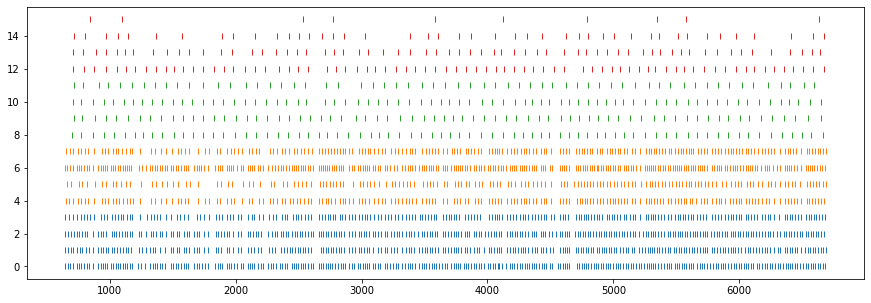

In [113]:
exc_spikes = spikes_array[spikes_array[:,1] < 256,:]
inh_spikes = spikes_array[spikes_array[:,1] >= 256,:]
e1 = exc_spikes[exc_spikes[:,1] < 4,:]
e2 = exc_spikes[exc_spikes[:,1] >= 4,:]
i1 = inh_spikes[inh_spikes[:,1]-256 < 4,:]
i2 = inh_spikes[inh_spikes[:,1]-256 >= 4,:]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()
ax.plot(e1[:,0]/1000, e1[:,1], '|')
ax.plot(e2[:,0]/1000, e2[:,1], '|')
ax.plot(i1[:,0]/1000, -256+8+i1[:,1], '|')
ax.plot(i2[:,0]/1000, -256+8+i2[:,1], '|')
plt.show()